In [1]:
import pennylane as qml
from pennylane import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# Data preparation

# Load digits dataset
digits = datasets.load_digits(n_class=2)

# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

# Reduce dimensions
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 100
X = sample_train[:train_size]
Y = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

# shift label from {0, 1} to {-1, 1}
Y = Y * 2 - np.ones(len(Y))
label_test = label_test * 2 - np.ones(len(label_test))

for i in range(10):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")

X = [-0.79923362 -0.26571862 -0.16474421 -0.17815209], Y = -1
X = [-0.81630337 -0.2918343  -0.48757339 -0.44903275], Y = -1
X = [-0.8857451  -0.29703903 -0.27973225  0.17301948], Y = -1
X = [-0.76039807 -0.27000038 -0.26925903  0.32714174], Y = -1
X = [-0.73871156 -0.11343435 -0.47219408 -0.49067011], Y = -1
X = [ 0.78786325 -0.59573349 -0.4920569   0.05387855], Y =  1
X = [ 0.39958822 -0.54294278  0.8919327  -0.61020082], Y =  1
X = [ 0.59776664 -0.3451937  -0.95910006  0.02118022], Y =  1
X = [ 0.21238989  0.90675747 -0.01334434 -0.16475638], Y =  1
X = [ 0.5672546  -0.35245554 -0.42810247  0.62548925], Y =  1
...


In [3]:
# Initialize quantum device
dev = qml.device("default.qubit", wires=4)

In [5]:
def statepreparation(x):
    for i in range(0,4):
        qml.RX(x[i],wires=i)

def layer(W):
    # parametrized RZ RY RZ rotations
    for i in range(0,3):
        for j in range(0,4):
            if i % 2 == 0:
                qml.RZ(W[j, i], wires=j)
            else:
                qml.RY(W[j, i], wires=j)
    
    # circular entanglement
    for i in range(0,3):
        qml.CNOT(wires=[i,i+1])
    qml.CNOT(wires=[3,0])

@qml.qnode(dev, interface="autograd")
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        try:
            layer(W)
        except:
            import pdb
            pdb.set_trace()

    return qml.expval(qml.PauliZ(0))

(<Figure size 1800x500 with 1 Axes>, <Axes: >)

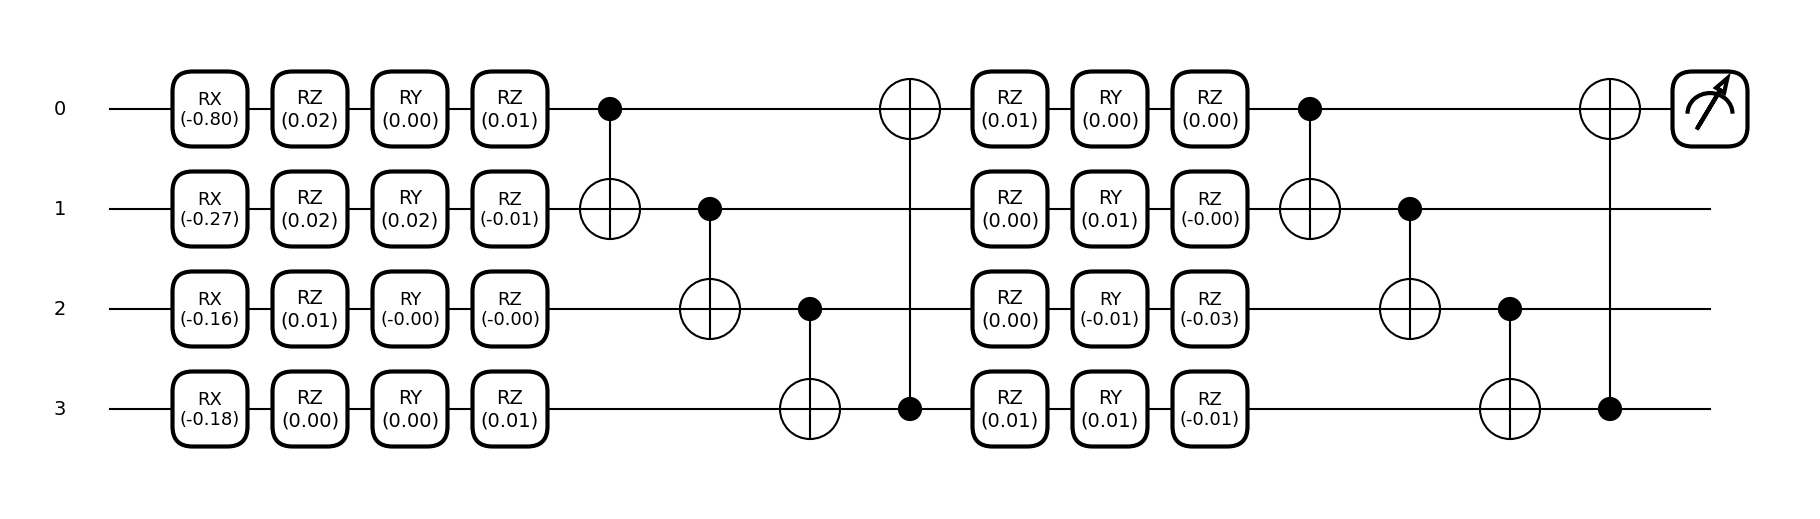

In [6]:
#Create initial weights from normal distribution
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)

#print initialized circuit
qml.draw_mpl(circuit,decimals=2, expansion_strategy='device')(weights_init,X[0])

In [7]:
# Cost and accuracy functions

def cost(weights, data, labels):
    predictions = [circuit(weights, x) for x in data]
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(weights, data, labels):
    predictions = [np.sign(circuit(weights, x)) for x in data]
    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)
    return acc

In [8]:
# Train model

weights = weights_init
opt = qml.GradientDescentOptimizer(stepsize=0.4)

for it in range(25):

    weights, _, _ = opt.step(cost, weights, X, Y)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, X, Y), accuracy(weights, X, Y)
        )
    )

cost:  Autograd ArrayBox with value [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
cost:  [[[ 0.01574464 -0.00288523  0.00978796]
  [ 0.02080179  0.02359029 -0.00976531]
  [ 0.00946168 -0.00141343 -0.00107218]
  [ 0.0040149   0.00178199  0.01453288]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00334283  0.0203357  -0.00205158]
  [ 0.00312572 -0.06934335 -0.0255299 ]
  [ 0.00658722  0.01186837 -0.00742165]]]
loss:  [[[ 0.01574464 -0.00288523  0.00978796]
  [ 0.02080179  0.02359029 -0.00976531]
  [ 0.00946168 -0.00141343 -0.00107218]
  [ 0.0040149   0.00178199  0.01453288]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00334283  0.0203357  -0.00205158]
  [ 0.00312572 -0.06934335 -0.0255299 ]
  [ 0.00658722  0.01

loss:  [[[ 1.48555628e-01 -1.95464646e-01  1.38975790e-02]
  [-1.57928510e-03  1.09938477e-01 -9.94515181e-03]
  [ 1.10483916e-02 -1.12340095e-02  1.77567885e-04]
  [ 7.32654046e-04  1.59722509e-02  1.50754386e-02]]

 [[ 7.61037725e-03  1.21675016e-03  4.43863233e-03]
  [ 6.80544107e-03  8.52859891e-02 -2.05158264e-03]
  [ 5.08196450e-03 -1.16172915e+00 -2.55298982e-02]
  [ 1.08643394e-02  7.62788360e-02 -7.42165020e-03]]]
Iter:     8 | Cost: 1.0010855 | Accuracy: 0.4700000 
cost:  Autograd ArrayBox with value [[[ 1.48555628e-01 -1.95464646e-01  1.38975790e-02]
  [-1.57928510e-03  1.09938477e-01 -9.94515181e-03]
  [ 1.10483916e-02 -1.12340095e-02  1.77567885e-04]
  [ 7.32654046e-04  1.59722509e-02  1.50754386e-02]]

 [[ 7.61037725e-03  1.21675016e-03  4.43863233e-03]
  [ 6.80544107e-03  8.52859891e-02 -2.05158264e-03]
  [ 5.08196450e-03 -1.16172915e+00 -2.55298982e-02]
  [ 1.08643394e-02  7.62788360e-02 -7.42165020e-03]]]
cost:  [[[ 1.82108786e-01 -2.31723980e-01  1.66339308e-02]
  [-3

cost:  Autograd ArrayBox with value [[[ 2.70910476e-01 -2.93205618e-01  4.66147818e-02]
  [-4.06163737e-03  1.20877751e-01 -8.81673215e-03]
  [ 2.83983801e-02 -8.14367460e-02  1.57566274e-02]
  [-1.45620254e-03  2.01681782e-02  1.59649721e-02]]

 [[ 7.61037725e-03  1.21675016e-03  4.43863233e-03]
  [ 3.63470878e-02  1.64920745e-01 -2.05158264e-03]
  [ 3.06585478e-02 -1.54854084e+00 -2.55298982e-02]
  [ 3.92130007e-02  1.84464145e-01 -7.42165020e-03]]]
cost:  [[[ 2.84488128e-01 -2.94047206e-01  5.85291738e-02]
  [-4.07731836e-03  1.21073820e-01 -8.15193364e-03]
  [ 3.28719831e-02 -1.00353038e-01  1.97031076e-02]
  [-1.75444686e-03  2.03397364e-02  1.58747418e-02]]

 [[ 7.61037725e-03  1.21675016e-03  4.43863233e-03]
  [ 4.73490833e-02  1.91722609e-01 -2.05158264e-03]
  [ 4.01677885e-02 -1.55694118e+00 -2.55298982e-02]
  [ 4.92585864e-02  2.17909365e-01 -7.42165020e-03]]]
loss:  [[[ 2.84488128e-01 -2.94047206e-01  5.85291738e-02]
  [-4.07731836e-03  1.21073820e-01 -8.15193364e-03]
  [ 3.

cost:  [[[ 4.73975012e-01 -2.54856137e-01  2.51418646e-01]
  [-4.60905479e-03  1.27866018e-01  2.32358013e-03]
  [ 7.01604172e-02 -2.64716757e-01  4.80691511e-02]
  [-3.23714911e-03  2.09088151e-02  1.50352035e-02]]

 [[ 7.61037725e-03  1.21675016e-03  4.43863233e-03]
  [ 2.26465353e-01  6.55500355e-01 -2.05158264e-03]
  [ 1.78724620e-01 -1.52164713e+00 -2.55298982e-02]
  [ 1.90805734e-01  7.21006102e-01 -7.42165020e-03]]]
loss:  [[[ 4.73975012e-01 -2.54856137e-01  2.51418646e-01]
  [-4.60905479e-03  1.27866018e-01  2.32358013e-03]
  [ 7.01604172e-02 -2.64716757e-01  4.80691511e-02]
  [-3.23714911e-03  2.09088151e-02  1.50352035e-02]]

 [[ 7.61037725e-03  1.21675016e-03  4.43863233e-03]
  [ 2.26465353e-01  6.55500355e-01 -2.05158264e-03]
  [ 1.78724620e-01 -1.52164713e+00 -2.55298982e-02]
  [ 1.90805734e-01  7.21006102e-01 -7.42165020e-03]]]
Iter:    21 | Cost: 0.5589677 | Accuracy: 0.9100000 
cost:  Autograd ArrayBox with value [[[ 4.73975012e-01 -2.54856137e-01  2.51418646e-01]
  [-4

In [9]:
# Evaluate model on test set; accuracy should be at least > 0.75

print("Evaluate test set:  Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            cost(weights, sample_test, label_test), accuracy(weights, sample_test, label_test)
        ))

cost:  [[[ 5.64709351e-01 -1.22085565e-01  3.59826718e-01]
  [-3.11749334e-03  1.29376156e-01  6.90644104e-03]
  [ 8.20788177e-02 -3.25194329e-01  5.34109843e-02]
  [-3.54885541e-03  2.20562367e-02  1.48535964e-02]]

 [[ 7.61037725e-03  1.21675016e-03  4.43863233e-03]
  [ 3.02025543e-01  1.09415384e+00 -2.05158264e-03]
  [ 1.76991359e-01 -1.50119404e+00 -2.55298982e-02]
  [ 1.83898576e-01  1.15981349e+00 -7.42165020e-03]]]
loss:  [[[ 5.64709351e-01 -1.22085565e-01  3.59826718e-01]
  [-3.11749334e-03  1.29376156e-01  6.90644104e-03]
  [ 8.20788177e-02 -3.25194329e-01  5.34109843e-02]
  [-3.54885541e-03  2.20562367e-02  1.48535964e-02]]

 [[ 7.61037725e-03  1.21675016e-03  4.43863233e-03]
  [ 3.02025543e-01  1.09415384e+00 -2.05158264e-03]
  [ 1.76991359e-01 -1.50119404e+00 -2.55298982e-02]
  [ 1.83898576e-01  1.15981349e+00 -7.42165020e-03]]]
Evaluate test set:  Cost: 0.4331384 | Accuracy: 0.8500000 
